In [3]:
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import array
from numpy.linalg import inv

In [7]:
ExampleTable = Table.read_table("U.S._Chronic_Disease_Indicators__CDI_.csv")

In [8]:
ExampleTable1 = ExampleTable.group("StratificationCategoryID3")

In [10]:
ExampleTable1

StratificationCategoryID3,count
,79188
nan,440530


In [9]:
ExampleTable2 = ExampleTable.group("Response")

In [11]:
ExampleTable2

Response,count
,79188
nan,440530


In [13]:
data = Table.read_table("U.S._Chronic_Disease_Indicators__CDI_.csv")\
.drop("StratificationCategoryID3", "StratificationID3","StratificationCategory3", "Stratification3", "Response",\
      "StratificationCategoryID1","StratificationID1","StratificationCategoryID2","StratificationID2","DataValueTypeID",\
      "QuestionID","TopicID","LocationID","ResponseID", "DataSource","GeoLocation","StratificationCategory2","Stratification2",\
     "LocationAbbr","YearEnd")

In [36]:
data.show(4)

YearStart,YearEnd,LocationDesc,Topic,Question,DataValueUnit,DataValueType,DataValue,DataValueAlt,DataValueFootnoteSymbol,DatavalueFootnote,LowConfidenceLimit,HighConfidenceLimit,StratificationCategory1,Stratification1
2015,2015,United States,Alcohol,Amount of alcohol excise tax by beverage type (wine),$,US Dollars,nan,nan,-,No data available,nan,nan,Overall,Overall
2012,2012,District of Columbia,Alcohol,Amount of alcohol excise tax by beverage type (beer),$,US Dollars,0.09,0.09,nan,nan,nan,nan,Overall,Overall
2012,2012,Guam,Alcohol,Amount of alcohol excise tax by beverage type (beer),$,US Dollars,nan,nan,-,No data available,nan,nan,Overall,Overall
2012,2012,Puerto Rico,Alcohol,Amount of alcohol excise tax by beverage type (beer),$,US Dollars,nan,nan,-,No data available,nan,nan,Overall,Overall


In [1]:
# TopicsTable = data.group("Topic")\
# .sort("count", descending = True)
# QuestionsTable = data.group("Question")\
# .sort("count", descending = True)
# LocationsTable = data.group("LocationDesc")\
# .sort("count", descending = True)
# Footnotes = data.group("DatavalueFootnote")\
# .sort("count", descending = True)
# FootNoteArray = Footnotes.column("DatavalueFootnote")
# TopicsTable.show()

In [6]:
#List of Questions
# questionsArray = QuestionsTable.column("Question")
# print("Number of questions: " + str(len(questionsArray)))
# for i in questionsArray:
#     print(i)
#     print()

In [16]:
diabetesTable = ExampleTable.where("Topic", are.equal_to("Diabetes"))\
.where("StratificationCategory1", are.equal_to("Overall"))\
.where("DataValueType", are.equal_to("Age-adjusted Prevalence"))\
.group("YearStart")

In [17]:
diabetesTable

YearStart,count
2011,660
2012,605
2013,660
2014,605
2015,660
2016,605


In [22]:
#Table with 12 questions, with samples from every territory, and is consistent over the years
diaTable = data.where("Topic", are.equal_to("Diabetes")).where("StratificationCategory1", are.equal_to("Overall"))\
.where("DataValueType", are.equal_to("Age-adjusted Prevalence"))\
.where("YearStart", are.not_equal_to(2012))\
.where("YearStart", are.not_equal_to(2014))\
.where("YearStart", are.not_equal_to(2016))\
.where("Question", are.not_equal_to("Dilated eye examination among adults aged >= 18 years with diagnosed diabetes"))\
.where("Question", are.not_equal_to("Foot examination among adults aged >= 18 years with diagnosed diabetes"))\
.where("Question", are.not_equal_to("Glycosylated hemoglobin measurement among adults aged >= 18 years with diagnosed diabetes"))\
.where("Question", are.not_equal_to("Prevalence of diagnosed diabetes among adults aged >= 18 years")) 
#Didn't include questions where their weight on life expectancy could go in either direction

In [23]:
# Made "Valid Diabetes Table, where it clears out a ton of null values we can't use"
ValidDT = diaTable.where("DataValue", are.not_equal_to("nan"))
#ValidDT.show(3)
def string_to_float(column_val):
    try:
        converted_val = float(column_val)
    except:
        print("Error")
    return converted_val
# Changes the string values in the row we need to floats
ValidDT_converted = ValidDT.with_columns("DataValue", \
                                         ValidDT.apply(string_to_float, "DataValue"))

In [24]:
Questions = diaTable.group("Question").column(0).tolist()
# These are now the only questions we will use that we think can help predict
# diabetes mortality rate
for i in Questions:
    print(i)

Adults with diagnosed diabetes aged >= 18 years who have taken a diabetes self-management course
Influenza vaccination among noninstitutionalized adults aged 18-64 years with diagnosed diabetes
Influenza vaccination among noninstitutionalized adults aged >= 65 years with diagnosed diabetes
Pneumococcal vaccination among noninstitutionalized adults aged 18-64 years with diagnosed diabetes
Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with diagnosed diabetes
Prevalence of depressive disorders among adults aged >= 18 years with diagnosed diabetes
Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes
Prevalence of high cholesterol among adults aged >= 18 years with diagnosed diabetes


In [25]:
#making a dictionary of States/Territories from the Taable
states = ValidDT.group("LocationDesc").column(0)
statesValues = {}
for i in states:
    if i not in ["United States", "District of Columbia", "Guam", "Puerto Rico"]:
        statesValues[i] = [1]

#   The Design Matrix    
#   We need this for doing Least squares regression on our 8-D data
#   Since we are using multiple features (8), it requires linear algebra
for q in Questions:
    ValidDT_Q = ValidDT_converted.where("Question", are.equal_to(q))
    overallMean = np.mean(ValidDT_Q.column("DataValue"))
    for s in statesValues.keys():
        ValidDT_Q_S = ValidDT_Q.where("LocationDesc", are.equal_to(s))
        curr_data = ValidDT_Q_S.column("DataValue")
        if len(curr_data) == 0:
            meanOfQues = overallMean
        else: 
            meanOfQues = sum(curr_data)/len(curr_data)
        statesValues[s] += [meanOfQues]
designMatrix = []
for i in statesValues.values():
    designMatrix += [i]
len(designMatrix)

50

In [26]:
#Using the formula associated with finding the vector of weights
# -> w = ((X^T x X)^-1)X^T(y)
designMatrixArray = array(designMatrix)
first = designMatrixArray.transpose().dot(designMatrixArray)
first = first = inv(first)
second = first.dot(designMatrixArray.transpose())


In [27]:
# Now I need a y vector, our predictions
# Using a seperate dataset of actual deaths, we could analzye y for each state
stateDeaths = Table.read_table("Diabetes Mortality by State.csv")\
.drop("URL", "DEATHS").where("STATE", are.not_equal_to("nan"))
# Had to clean up the original data set first though
statesDict = {
        'AK': 'Alaska','AL': 'Alabama','AR': 'Arkansas','AS': 'American Samoa','AZ': 'Arizona','CA': 'California','CO': 'Colorado',
        'CT': 'Connecticut','DC': 'District of Columbia','DE': 'Delaware','FL': 'Florida','GA': 'Georgia','GU': 'Guam',
        'HI': 'Hawaii','IA': 'Iowa','ID': 'Idaho','IL': 'Illinois','IN': 'Indiana','KS': 'Kansas','KY': 'Kentucky','LA': 'Louisiana',
        'MA': 'Massachusetts','MD': 'Maryland','ME': 'Maine','MI': 'Michigan','MN': 'Minnesota','MO': 'Missouri',
        'MP': 'Northern Mariana Islands','MS': 'Mississippi','MT': 'Montana','NA': 'National','NC': 'North Carolina',
        'ND': 'North Dakota','NE': 'Nebraska','NH': 'New Hampshire','NJ': 'New Jersey',
        'NM': 'New Mexico','NV': 'Nevada','NY': 'New York','OH': 'Ohio','OK': 'Oklahoma','OR': 'Oregon','PA': 'Pennsylvania',
        'PR': 'Puerto Rico','RI': 'Rhode Island','SC': 'South Carolina','SD': 'South Dakota','TN': 'Tennessee','TX': 'Texas',
        'UT': 'Utah','VA': 'Virginia','VI': 'Virgin Islands','VT': 'Vermont','WA': 'Washington','WI': 'Wisconsin',
        'WV': 'West Virginia','WY': 'Wyoming'
}
#making yVector
def translateName(abrev):
    return statesDict[abrev]
stateDeaths = stateDeaths.with_columns("STATE", stateDeaths.apply(translateName, "STATE"))
def convertToRatio(rate):
    return rate/100_000
stateDeaths = stateDeaths.with_columns("PROPORTION", stateDeaths.apply(convertToRatio, "RATE"))
yVector = stateDeaths.where("YEAR", are.equal_to(2017)).column("PROPORTION")

In [28]:
weightsVector = second.dot(yVector)
weightsVector

array([ 6.17561415e-06,  1.39228305e-06, -3.12634037e-07,  1.19192175e-06,
       -2.72729756e-06,  1.00450849e-06,  2.49099914e-06,  2.31845173e-06,
       -1.82664809e-06])

In [29]:
Questions

['Adults with diagnosed diabetes aged >= 18 years who have taken a diabetes self-management course',
 'Influenza vaccination among noninstitutionalized adults aged 18-64 years with diagnosed diabetes',
 'Influenza vaccination among noninstitutionalized adults aged >= 65 years with diagnosed diabetes',
 'Pneumococcal vaccination among noninstitutionalized adults aged 18-64 years with diagnosed diabetes',
 'Pneumococcal vaccination among noninstitutionalized adults aged >= 65 years with diagnosed diabetes',
 'Prevalence of depressive disorders among adults aged >= 18 years with diagnosed diabetes',
 'Prevalence of high blood pressure among adults aged >= 18 years with diagnosed diabetes',
 'Prevalence of high cholesterol among adults aged >= 18 years with diagnosed diabetes']

In [30]:
PredictedWeight = ["-","-","+","-","+","+","+","+"]
correct = [False,True,True,True,True,True,True,False]
NLPExpectedInf = ["=","=","=","=","-","=","-","="]
finalTable = Table().with_columns("Weights", weightsVector[1:])\
.with_columns("Questions", Questions)\
.with_columns("ExectedInfluence", PredictedWeight)\
.with_columns("CorrectInfluence?", correct)\
.with_columns("NLPExpectedInf", NLPExpectedInf)
finalTable.show()
#This table is our first example at trying to use question answers to predict diabetes deaths

Weights,Questions,ExectedInfluence,CorrectInfluence?,NLPExpectedInf
1.39228e-06,Adults with diagnosed diabetes aged >= 18 years who have ...,-,False,=
-3.12634e-07,Influenza vaccination among noninstitutionalized adults ...,-,True,=
1.19192e-06,Influenza vaccination among noninstitutionalized adults ...,+,True,=
-2.7273e-06,Pneumococcal vaccination among noninstitutionalized adul ...,-,True,=
1.00451e-06,Pneumococcal vaccination among noninstitutionalized adul ...,+,True,-
2.491e-06,Prevalence of depressive disorders among adults aged >= ...,+,True,=
2.31845e-06,Prevalence of high blood pressure among adults aged >= 1 ...,+,True,-
-1.82665e-06,Prevalence of high cholesterol among adults aged >= 18 y ...,+,False,=


Adults with diagnosed diabetes aged >= 18 years who have taken a diabetes self-management course


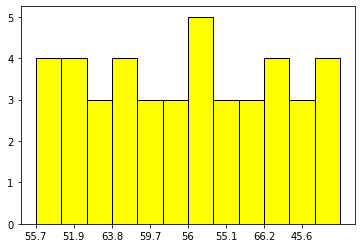

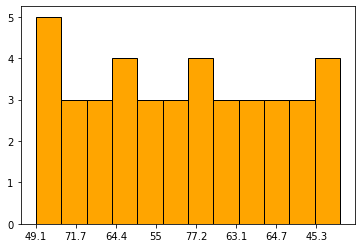

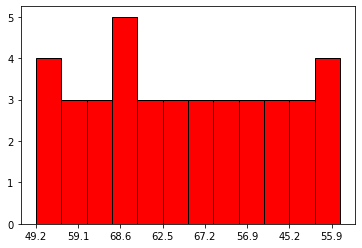

Influenza vaccination among noninstitutionalized adults aged 18-64 years with diagnosed diabetes


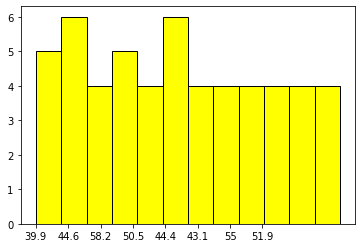

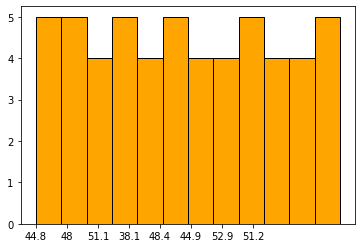

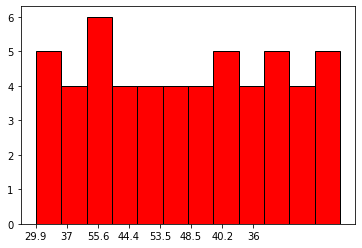

Influenza vaccination among noninstitutionalized adults aged >= 65 years with diagnosed diabetes


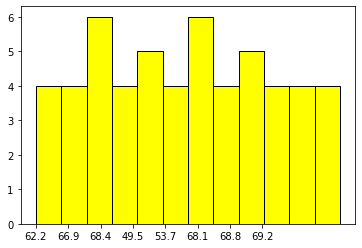

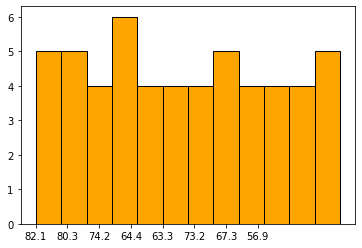

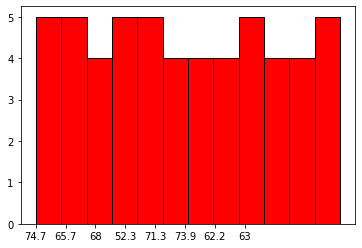

In [33]:
QuestionsTester = Questions[:3]
for i in QuestionsTester:
    print(i)
    for j in [2011, 2013, 2015]:
        currColor = "blue"
        if j == 2011:
            currColor = "yellow"
        elif j == 2013:
            currColor = "orange"
        elif j == 2015:
            currColor = "red"
    
        smallSample = ValidDT.where("Question", are.equal_to(i)).where("YearStart", are.equal_to(j))
        sampleBit = smallSample.column("DataValue")
        plt.hist(sampleBit, bins = 12, color=currColor)
        plt.xticks(np.arange(0,40,5))
        plt.show()

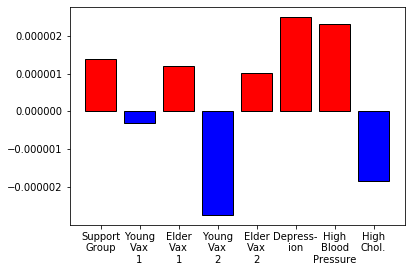

In [86]:
#Visualized, the estimated effect of each weight on the proportion of diabetes mortalities in a state
smallSample = finalTable.column("Weights")
#sampleBit = smallSample.column("DataValue")
plt.bar(["Support\nGroup", "Young\nVax\n1", "Elder\nVax\n1", "Young\nVax\n2", "Elder\nVax\n2","Depress-\nion","High\nBlood\nPressure","High\nChol."], smallSample,\
       color = ["red", "blue","red", "blue","red","red","red","blue" ])
plt.show()